In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import glob
import pandas as pd
from collections import OrderedDict

In [2]:
directories = glob.glob('.experiments/multi-point_200000-validation_I_think/*/*/result*.pth')

#load each 
results = {}
seed = 0
is_one_model = False
for pth in directories:
    dt = pth.split('/')[-1].split('-dt-')[-1].split('-')[0]
    algorithm = pth.split('/')[2] + '-' + dt
    
    result = torch.load(pth)
    if algorithm in results and not is_one_model:
        start = len(results[algorithm])
        end = len(results[algorithm]) + len(result)
        j = 0
        for i in range(start, end):
            results[algorithm][i] = result[j]
            j += 1        
    elif algorithm in results and is_one_model:
        results[algorithm + "-" + str(seed)] = result
        seed += 1
    else:
        results[algorithm] = result
    

In [3]:
results.keys()

dict_keys(['broyden-results', 'global-neuralnetwork-custom-results', 'local-uvs-results', 'knn-neuraljacobian-custom-results', 'multipoint-inversejacobian-results', 'global-locallinear-kd-results', 'blackbox-kinematics-custom-results', 'multitask-knn-neuraljacobian-custom-results', 'global-neuralnetwork-multitask-custom-results'])

In [4]:
labels = [
            ("multipoint-inversejacobian-results", "True Jacobian"),
            ("broyden-results", "Broyden"),
          ("local-uvs-results", "Finite Difference"),
            ("global-locallinear-kd-results", "KNN Local Linear"),
          ("blackbox-kinematics-custom-results", "Neural Kinematics"),
          ("global-neuralnetwork-custom-results", "Neural Jacobian"),
          ("global-neuralnetwork-multitask-custom-results", "Multitask Neural Jacobian"),
        #("knn-neuraljacobian-custom-results", "KNN Neural Jacobian"),
        #("multitask-knn-neuraljacobian-custom-results", "Multitask KNN Neural Jacobian")
         ]
labels = OrderedDict(labels)
new_results = []
for label in labels:
    for k in results.keys():
        if label == k:
            print(k, label)
            new_results.append([labels[label], results[k]])
            
results = new_results

results = OrderedDict(new_results)



multipoint-inversejacobian-results multipoint-inversejacobian-results
broyden-results broyden-results
local-uvs-results local-uvs-results
global-locallinear-kd-results global-locallinear-kd-results
blackbox-kinematics-custom-results blackbox-kinematics-custom-results
global-neuralnetwork-custom-results global-neuralnetwork-custom-results
global-neuralnetwork-multitask-custom-results global-neuralnetwork-multitask-custom-results


In [5]:
results.keys()

odict_keys(['True Jacobian', 'Broyden', 'Finite Difference', 'KNN Local Linear', 'Neural Kinematics', 'Neural Jacobian', 'Multitask Neural Jacobian'])

# Plot Error Curves
In this section we want to see if our Jacobian estimates with our neural network actually solve the undlerying task of interest (i.e. moving the end effector to some target position)

In [6]:
def collect_eps_errs(result, dim=-1):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            state = v[5] #should be....state
            if dim < 0:
                psn = state[0:12]
                targ = state[-12:]
                mse = np.linalg.norm(targ - psn, 2)
                
            else:
                psn = state[dim]
                targ = state[-12 + dim]
                mse = np.sqrt((targ - psn) ** 2)
            episode_err.append(mse)
        err_over_time.append(episode_err)
    return np.array(err_over_time).T

def plot_mu_sig(data, label=None, axis=1, ax=None,line_stype='b-'):
    samples = np.array(data)
    mean = samples.mean(axis=axis)
    std = samples.std(axis=axis)
    ste = std / np.sqrt(samples.shape[1]) #this is a hack, if axis not == 1, this will break
    
    ax.plot(mean,line_stype, label=label)
    #ax.errorbar(list(range(mean.shape[0])), mean, yerr=std /np.sqrt(samples.shape[0]) , label=label)
    ax.fill_between(list(range(mean.shape[0])), mean + ste, mean - ste, color=line_stype[0], alpha=0.1)

In [7]:
err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time

In [8]:
line_types = [
            ("True Jacobian", "b|-"),
            ("KNN Local Linear", "g--"),
            ("Broyden", "r-d"),
          ("Finite Difference", "c-."),
          ("Neural Kinematics", "m-"),
          ("Neural Jacobian", "y:"),
          ("Multitask Neural Jacobian", "k--"),
          #("KNN Neural Jacobian", "b"),
          #("Multitask KNN Neural Jacobian", "c")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['True Jacobian', 'KNN Local Linear', 'Broyden', 'Finite Difference', 'Neural Kinematics', 'Neural Jacobian', 'Multitask Neural Jacobian'])

96
393
464
147


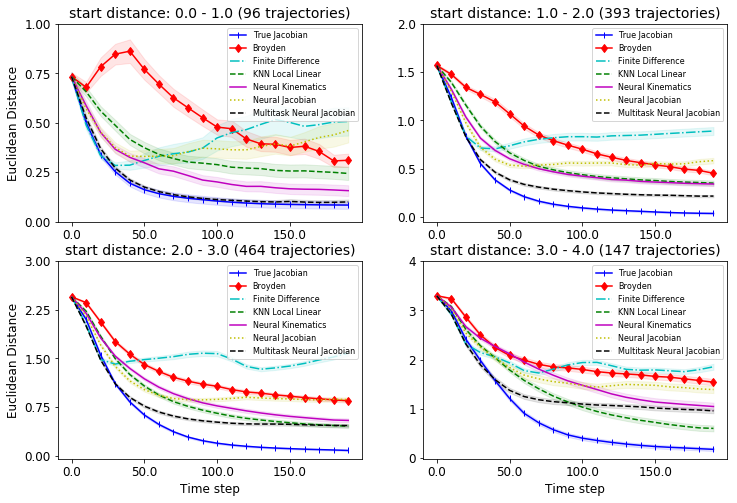

In [9]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE + 2)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    
bounds = [0.0, 1.0, 2.0, 3.0, 4.0]
n_plts = len(bounds) - 1
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = np.ndarray.flatten(axs)
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    num_trajs = 0.0
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        num_trajs = np.sum(to_plot)
        line_type = line_types[algorithm]
        plot_mu_sig(err_over_time[0:200:10, to_plot], label=algorithm, ax=ax, line_stype=line_type)
    
    print(num_trajs)
    ax.get_yaxis().set_ticks(np.linspace(0.0, end, 5))
    ax.legend()
    ax.set_title("start distance: {} - {} ({} trajectories)".format(start, end, num_trajs))
    
    i += 1
    if i == 1 or i == 3:
        ax.set_ylabel("Euclidean Distance")
    
    if i == len(bounds) - 1 or i == 3:
        ax.set_xlabel("Time step")

    ax.set_xticklabels(labels = 20* np.arange(-2.5, 20, 2.5))
        
        
    
plt.savefig('multi_pt_error_curves.pdf',bbox_inches = 'tight',
    pad_inches = 0.1) 

# Violin Plots of End Performance

In this section we focus on the performance at the end of each episode. specifically whether or not the target was reached

In [10]:

violin_results = []
for algorithm, result in results.items():
    print(algorithm)
    err_over_time = collect_eps_errs(result, dim=-1)
    violin_results.append([algorithm, err_over_time])
    
violin_results = OrderedDict(violin_results)

True Jacobian
Broyden
Finite Difference
KNN Local Linear
Neural Kinematics
Neural Jacobian
Multitask Neural Jacobian


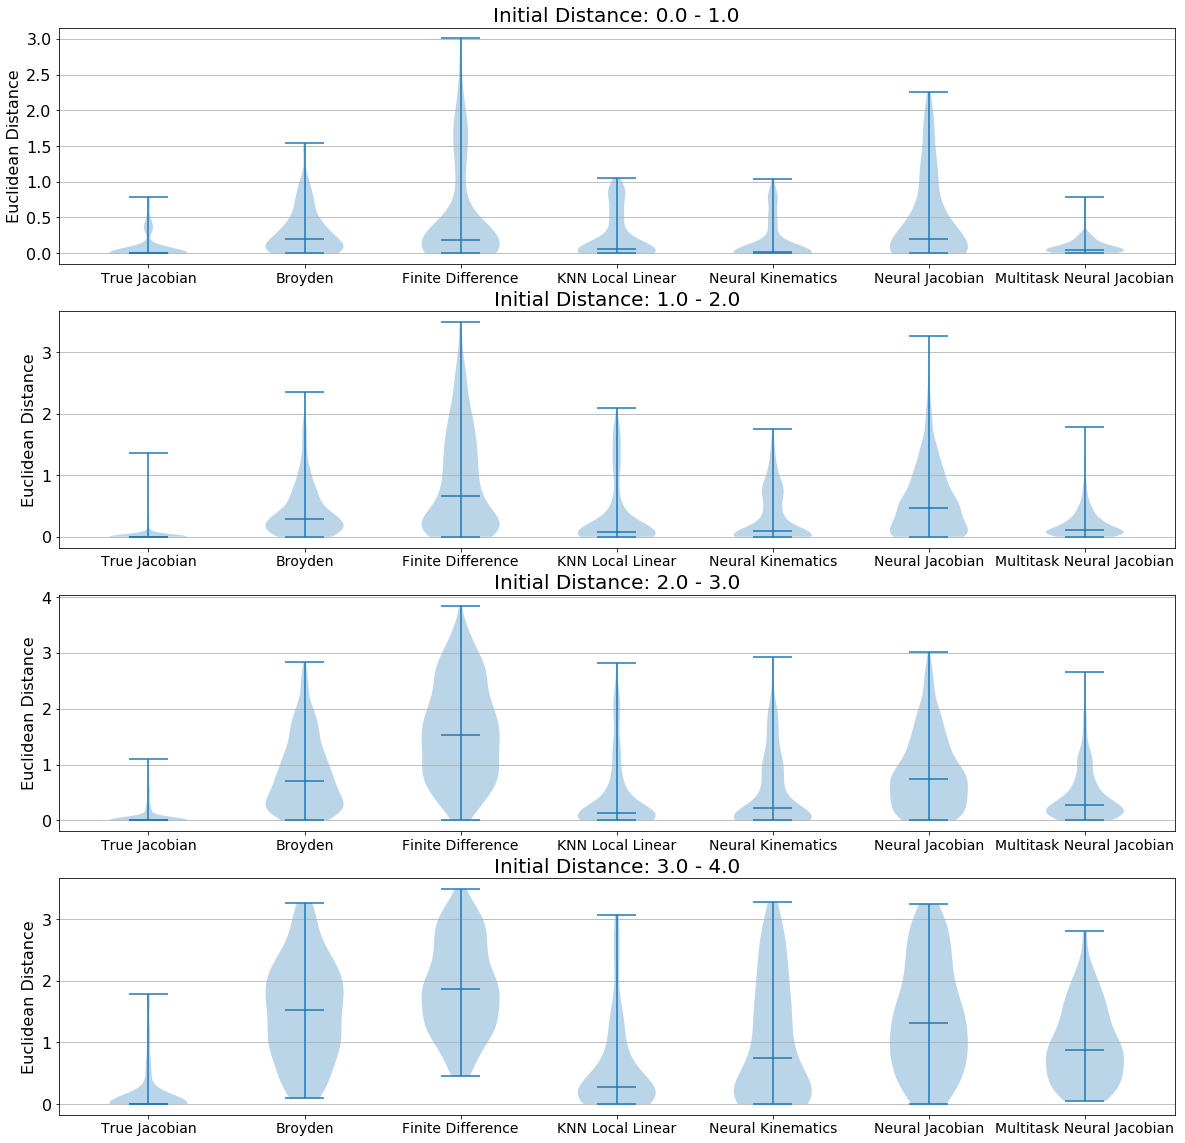

In [11]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig, axs = plt.subplots(4, 1, figsize=(20, 20))


bounds = [0.0, 1.0, 2.0, 3.0, 4.0]
successTable = {}
i = 0
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    end_dists = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        
        percentage = to_plot.sum() / count[-1]
        end_dist = err_over_time[-1, to_plot]  # for delta t between each timestep
        #end_dist = end_dist[to_plot]
        
        
        end_dists.append(end_dist)
        labels.append(algorithm)
    ax = axs[i]
    i+= 1
    ax.violinplot(end_dists, showmeans=False, showmedians=True)
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels([l.format(len(a)) for l, a in zip(labels, end_dists)])
    ax.yaxis.grid(True)
    ax.set_ylabel("Euclidean Distance")
    ax.set_title("Initial Distance: {} - {}".format(low, high))

plt.savefig('multi_pt_violion_end_position.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

# These are just tables of statistics from the trajectories 
The basic question is whether or not they reached the target. 
We considered the target reached by some threshold


In [12]:
err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time


In [13]:

successTable = {}
thresh=0.05
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        to_plot = np.logical_and(to_plot, err_over_time[-1,:] <= thresh)

        percentage = to_plot.sum() / count[-1] * 100.0 #so it's between 0 - 100%

        if not algorithm in successTable:
            successTable[algorithm] = {"{}m - {}m".format(low,high): percentage}
        else:
            successTable[algorithm]["{}m - {}m".format(low,high)] = percentage
    
        labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    succeses = (err_over_time[-1,:] <= thresh)
    percentage = succeses.sum() / err_over_time.shape[1] * 100.0 #so it's between 0 - 100%
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in successTable:
            successTable[algorithm] = {"Overall": percentage}
    else:
        successTable[algorithm]["Overall"] = percentage
    
successTable = pd.DataFrame.from_dict(successTable).round(2).transpose()
successTable

,0.0m - 1.0m,1.0m - 2.0m,2.0m - 3.0m,3.0m - 4.0m,Overall
Broyden,28.12,15.27,3.45,0.00,9.36
Finite Difference,23.96,9.67,1.29,0.00,6.09
KNN Local Linear,45.83,41.73,32.33,14.29,34.45
Multitask Neural Jacobian,50.00,24.17,10.56,0.00,17.45
Neural Jacobian,39.58,22.90,9.05,3.40,15.91
Neural Kinematics,70.83,45.80,36.21,17.01,40.09
True Jacobian,80.21,89.82,78.88,76.87,82.64


In [14]:
#Get bounds from inverse kinematics
iJ_bounds = {}
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:
    err_over_time = violin_results["True Jacobian"]
    to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)

    final_errs = err_over_time[-1,to_plot]
    mini = min(final_errs)
    maxi = max(final_errs)

    iJ_bounds["{}-{}".format(low,high)] = {"low": mini , "high":maxi}
    
print(iJ_bounds)

{'3.0-4.0': {'low': 0.00016199108408515656, 'high': 1.792254238850206}, '1.0-2.0': {'low': 3.141342106768093e-05, 'high': 1.363178489848008}, '0.0-4.0': {'low': 6.451189938669607e-06, 'high': 1.792254238850206}, '0.0-1.0': {'low': 6.451189938669607e-06, 'high': 0.7893651602965008}, '2.0-3.0': {'low': 7.4351455872066e-05, 'high': 1.1062787980842346}}


In [15]:
successesTable = {}
count = []
step_size = 0.001
max_thresh = 0.25
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        ij_b = iJ_bounds["{}-{}".format(low,high)]
        
        #step_size = (ij_b["high"] - ij_b["low"] ) / 100
        #range_to_thresh = np.arange(ij_b["low"], ij_b["high"] + step_size, step_size )
        range_to_thresh = np.arange(0, max_thresh, 0.001)
        for thresh in range_to_thresh:
            success = np.logical_and(to_plot, err_over_time[-1,:] <= thresh)

            percentage = success.sum() / count[-1] * 100.0 #so it's between 0 - 100%
            key = "{} - {}".format(low,high)
            if key == "{} - {}".format(bounds[0], bounds[-1]):
                key = "Overall"
            if not algorithm in successesTable:
                successesTable[algorithm] = {key: [percentage]}
            elif  key not in successesTable[algorithm] :
                successesTable[algorithm][key] = [percentage]
            else:
                successesTable[algorithm][key].append(percentage)
            


In [16]:
successes_auc_success_thresh = {}

num_thresh = len(np.arange(0, max_thresh, 0.001))
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:

    i += 1
    key = "{} - {}".format(low, high)
    if key == "{} - {}".format(bounds[0], bounds[-1]):
        key = "Overall"
    ij_b = iJ_bounds["{}-{}".format(low,high)]
    step_size = (ij_b["high"] - ij_b["low"] ) / num_thresh
    for algorithm in successesTable.keys():
        percentages = successesTable[algorithm][key]
        if not algorithm in successes_auc_success_thresh:
            successes_auc_success_thresh[algorithm] = {key: sum(percentages) / num_thresh }
        elif  key not in successes_auc_success_thresh[algorithm] :
            successes_auc_success_thresh[algorithm][key] = sum(percentages) / num_thresh

successes_auc_success_thresh_table = pd.DataFrame.from_dict(successes_auc_success_thresh).round(2).transpose()
successes_auc_success_thresh_table

,0.0 - 1.0,1.0 - 2.0,2.0 - 3.0,3.0 - 4.0,Overall
Broyden,38.30,24.49,10.46,1.59,16.72
Finite Difference,38.02,17.65,2.09,0.00,10.51
KNN Local Linear,56.76,52.35,43.99,28.90,46.08
Multitask Neural Jacobian,65.72,43.92,24.13,5.98,32.40
Neural Jacobian,42.70,27.19,13.31,5.27,19.76
Neural Kinematics,71.15,49.88,41.58,22.69,44.60
True Jacobian,81.45,91.57,82.07,78.47,84.93


In [17]:
line_types = [
            ("True Jacobian", "b|-"),
            ("KNN Local Linear", "g--"),
            ("Broyden", "r-d"),
          ("Finite Difference", "c-."),
          ("Neural Kinematics", "m-"),
          ("Neural Jacobian", "y:"),
          ("Multitask Neural Jacobian", "k--"),
          #("KNN Neural Jacobian", "b"),
          #("Multitask KNN Neural Jacobian", "c-.")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['True Jacobian', 'KNN Local Linear', 'Broyden', 'Finite Difference', 'Neural Kinematics', 'Neural Jacobian', 'Multitask Neural Jacobian'])

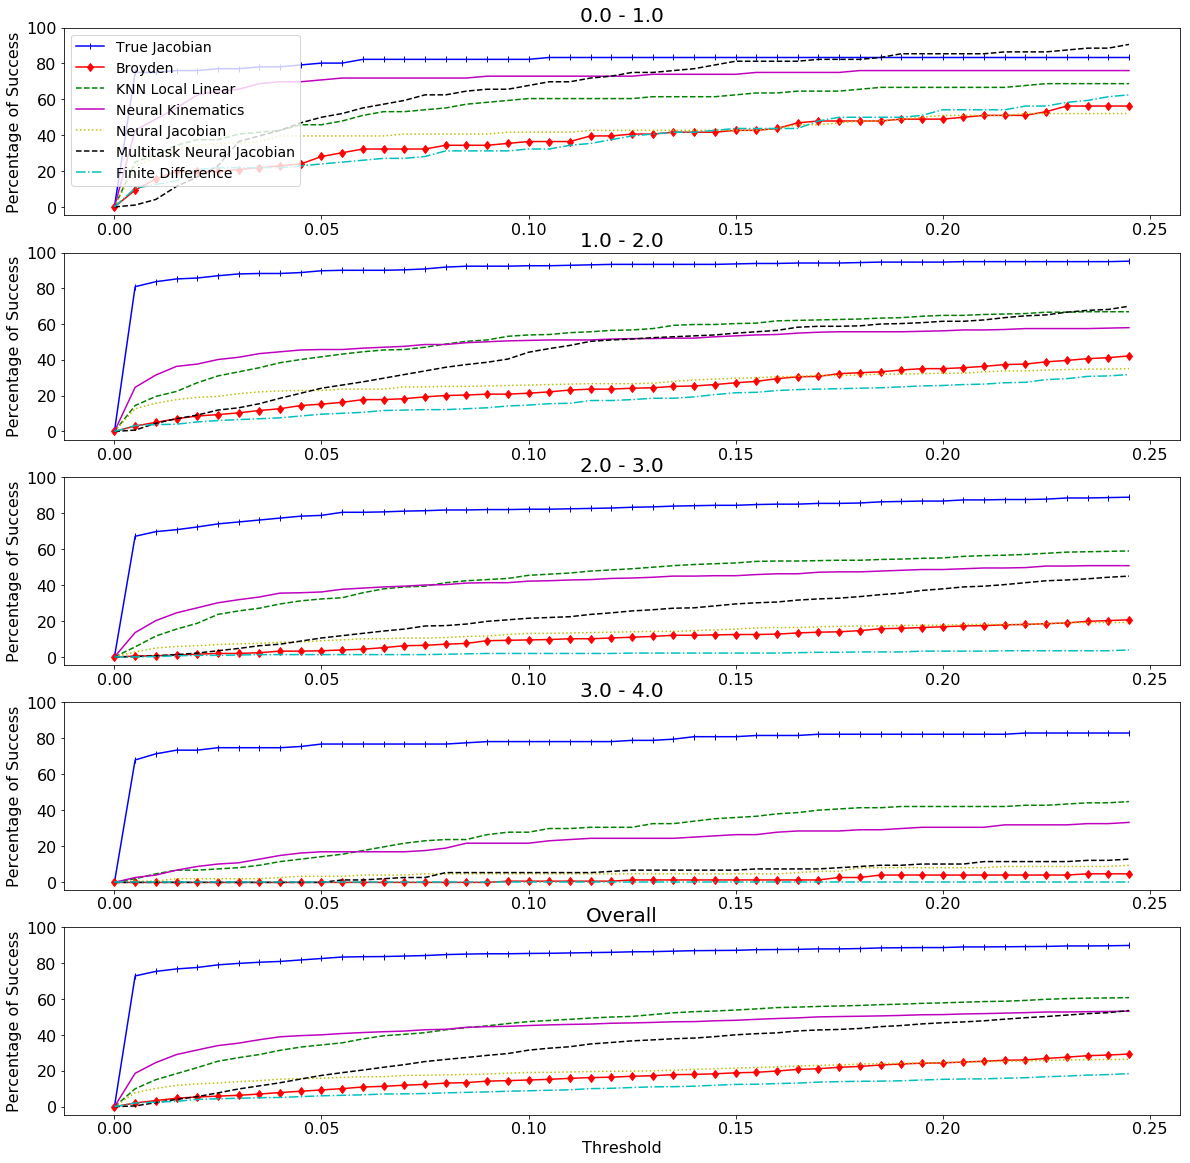

In [18]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig, axs = plt.subplots(5, 1, figsize=(20, 20))

i = 0
num_thresh = len(np.arange(0, max_thresh, 0.001))
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:
    ax = axs[i]
    i += 1
    key = "{} - {}".format(low, high)
    if key == "{} - {}".format(bounds[0], bounds[-1]):
        key = "Overall"
    ij_b = iJ_bounds["{}-{}".format(low,high)]
    #step_size = (ij_b["high"] - ij_b["low"] ) / 100
    #range_to_thresh = np.arange(ij_b["low"], ij_b["high"], step_size )
    range_to_thresh = np.arange(0, max_thresh, 0.001)
    for algorithm in successesTable.keys():
        result = successesTable[algorithm][key]
        line_style = line_types[algorithm]
        ax.plot(range_to_thresh[0:-1:5], result[0:-1:5], line_style, label=algorithm)
    if i == 1:
        ax.legend()
    ax.set_title(key)
    #ax.set_xticklabels(labels = ["{:.3f}".format(v) for v in np.arange(0 - 0.04166, .25, 0.04166)])
    ax.set_ylabel("Percentage of Success")
    ax.set_yticks([i for i in range(0, 110, 20)])
    if i == len(axs):
        ax.set_xlabel("Threshold")

In [19]:
end_dist_table = {}
end_dist_table_std = {}
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        end_diff = err_over_time[-1,:]
        end_diff = end_diff[to_plot]
        
        
        mu = end_diff.mean()
        std = end_diff.std() / np.sqrt(np.sum(to_plot))
        algorithm = algorithm.split('-results')[0]
        if "global-" in algorithm:
            algorithm = algorithm.split('global-')[-1]
        
        if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"{}m - {}m".format(low,high): mu}
            end_dist_table_std[algorithm] = {"{}m - {}m".format(low,high): std}
        else:
            end_dist_table[algorithm]["{}m - {}m".format(low,high)] = mu
            end_dist_table_std[algorithm]["{}m - {}m".format(low,high)] = std
            
        if "global-neuralnetwork" in algorithm:
            labels.append(algorithm.split("global-")[-1])
        else:
            labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    end_diff = err_over_time[-1,:]
    mu = end_diff.mean()
    std = end_diff.std()  / np.sqrt(np.sum(to_plot)) #ste
    
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"Overall": mu}
            end_dist_table_std[algorithm] = {"Overall".format(low,high): std}
    else:
        end_dist_table[algorithm]["Overall"] = mu
        end_dist_table_std[algorithm]["Overall"] = std
        
    
end_dist_table = pd.DataFrame.from_dict(end_dist_table).round(3).transpose()
end_dist_table_std = pd.DataFrame.from_dict(end_dist_table_std).round(3).transpose()
end_dist_table

,0.0m - 1.0m,1.0m - 2.0m,2.0m - 3.0m,3.0m - 4.0m,Overall
Broyden,0.304,0.432,0.837,1.521,0.737
Finite Difference,0.512,0.900,1.601,1.885,1.293
KNN Local Linear,0.238,0.344,0.451,0.583,0.412
Multitask Neural Jacobian,0.104,0.218,0.464,0.961,0.411
Neural Jacobian,0.473,0.579,0.872,1.414,0.805
Neural Kinematics,0.155,0.337,0.539,1.035,0.500
True Jacobian,0.080,0.034,0.077,0.164,0.073


# Comparing Jacobians

Here, we just calaculate the difference between Jacobians in trajectories to see how much they differ from the true underlying Jacobian

In [20]:
def collect_jacobian_dist(result, norm=None):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            estimate_J = v[-2] 

            true_J = v[-1]
            if norm is not "signs":
                mse = np.linalg.norm(estimate_J - true_J, norm) #, 'fro')
            else:
                sign_mismatch = np.logical_not(np.logical_and(estimate_J, true_J))
                mse = (sign_mismatch).sum() #techinically not mind you...
            episode_err.append(mse)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

In [21]:
line_types = [
            ("True Jacobian", "b|-"),
            ("KNN Local Linear", "g--"),
            ("Broyden", "r-d"),
          ("Finite Difference", "c-."),
          ("Neural Kinematics", "m-"),
          ("Neural Jacobian", "y:"),
          ("Multitask Neural Jacobian", "k--"),
          #("KNN Neural Jacobian", "b"),
          #("Multitask KNN Neural Jacobian", "c-.")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['True Jacobian', 'KNN Local Linear', 'Broyden', 'Finite Difference', 'Neural Kinematics', 'Neural Jacobian', 'Multitask Neural Jacobian'])

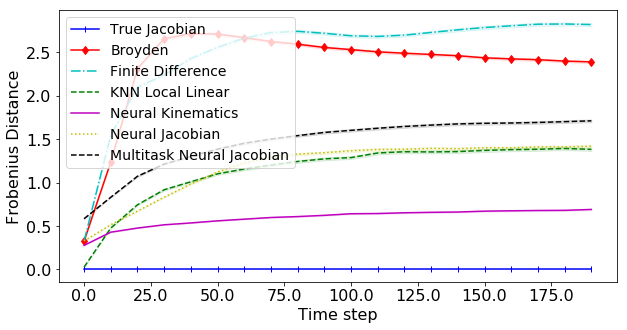

In [22]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#Focusing only on the frobenius norm
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for algorithm, result in results.items():
    jac_err = collect_jacobian_dist(result)
    line_type = line_types[algorithm]
    plot_mu_sig(jac_err[0:200:10, :], label=algorithm, ax=ax, line_stype=line_type)

ax.set_xticklabels(labels = 10* np.arange(-2.5, 20, 2.5))      
ax.set_xlabel('Time step')
ax.set_ylabel('Frobenius Distance')
#ax.set_title("Jacobian Differences")
ax.legend()
plt.savefig('multi_pt_jacobian_diff_global.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

In [23]:
#collects results for plotting histograms and trajectories
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

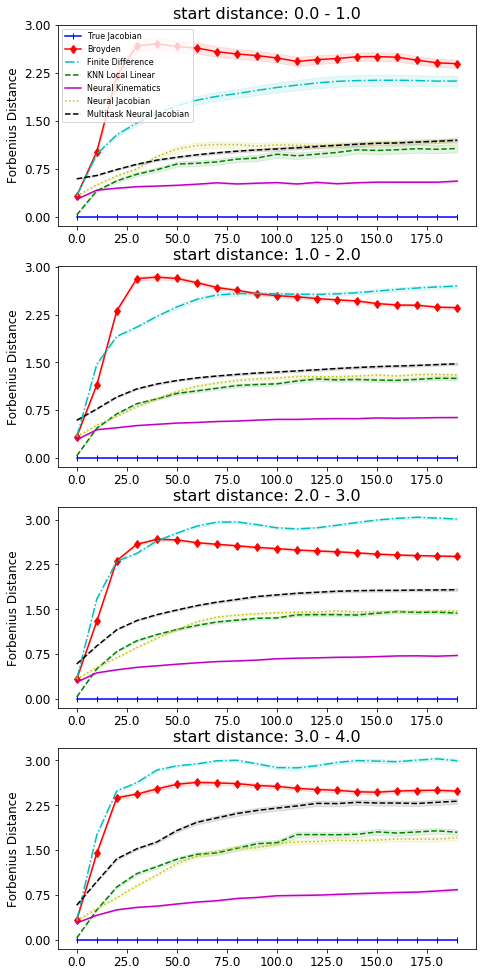

In [24]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bounds = [0.0, 1.0, 2.0, 3.0, 4.0]
fig, axs = plt.subplots(4, 1, figsize=(7.5, 17))
axs = np.ndarray.flatten(axs)
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        line_type = line_types[algorithm]
    
        plot_mu_sig(jac_errs[algorithm][0:200:10,to_plot], label=algorithm, ax=ax, line_stype=line_type)
        
    
    
    ax.get_yaxis().set_ticks(np.linspace(0.0, 3.0, 5))
    if i == 0:
        ax.legend()
    ax.set_title("start distance: {} - {}".format(start, end))
    
    #    ax.get_xaxis().set_ticks([])
    if i == 6: 
        ax.set_xlabel("Time step")
    
    ax.set_ylabel("Forbenius Distance")
    ax.set_xticklabels(labels = 10* np.arange(-2.5, 20, 2.5))
    i += 1
    
plt.savefig('multi_pt_jacobian_diff_by_dist.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

# Histograms of Jacobian difference
The previous plots were for trends over trajectories. The Jacobian differences are really independent of timesteps so to get a sense of these differences we visualize the results with histograms 


In [25]:
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

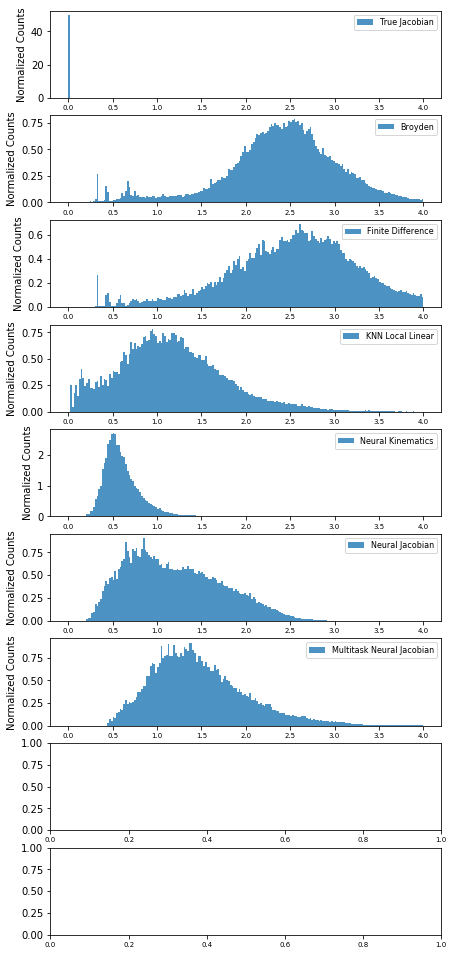

In [26]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE -1)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Focusing only on the frobenius norm
fig, axs = plt.subplots(9, 1, figsize=(7, 17))
axs = np.ndarray.flatten(axs)
i = 0
for algorithm, result in results.items():
    if "Inverse" in algorithm:
        continue
    ax = axs[i]
    i += 1
    jac_err = jac_err = jac_errs[algorithm]
    jac_err = jac_err.flatten()

    ax.hist(jac_err, bins=200, alpha=0.8, density=True, range=(0, 4), label= algorithm)
    ax.legend()
    #ax.set_title(algorithm)
    #if i == 1 or i == 4:
    ax.set_ylabel('Normalized Counts')
    if i == 6:
        ax.set_xlabel("Frobenius Error")

    #    ax.set_xticks([])
    #if i == (len(results) - 1) or i == 4 or i == 6 or i == 5:
    #    ax.set_xlabel('Frobenius Error')

plt.savefig('multi_pt_jacobian_hist.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)  

# On the rank of our Jacobian
In these plots we're mostly interested in seeing whether or not our Jacobian's are full rank or not. 
We also consider the ratio of the maximum to minimum singular values of the jacobian to see if we are in singularity configurations

In [27]:
def check_jacobian_dexterity(result):
    #we use 3rd dexterity definition in : 
    #https://vtechworks.lib.vt.edu/bitstream/handle/10919/30363/Chap4.pdf?sequence=7&isAllowed=y
    #this is just ratio of largest to smallest singular values 
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            n, m = J_hat.shape
            smaller_dims = min(n, m)
            _, s, _ = np.linalg.svd(J_hat, full_matrices=False, compute_uv=True, hermitian=False)
            s = s[:smaller_dims] #to determine if full rank on smaller dimension...i.e. the rows for me
            loss = max(s) / min(s)
            #loss = np.all((s > 0)) #if all greater than 0 implies fu
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

def check_jacobian_rank(result):
    #we use 3rd dexterity definition in : 
    #https://vtechworks.lib.vt.edu/bitstream/handle/10919/30363/Chap4.pdf?sequence=7&isAllowed=y
    #this is just ratio of largest to smallest singular values 
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            n, m = J_hat.shape
            smaller_dims = min(n, m)
            _, s, _ = np.linalg.svd(J_hat, full_matrices=False, compute_uv=True, hermitian=False)
            s = s[:smaller_dims] #to determine if full rank on smaller dimension...i.e. the rows for me
            loss = np.all((s > 0.001)) #if all greater than 0.1 not super close to a singularity
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

In [28]:
singular_values = {} 
for algorithm, result in results.items():
    if "inverse" in algorithm:
        continue
    singular_val_ratio = check_jacobian_dexterity(result)
    singular_values[algorithm] = singular_val_ratio
    

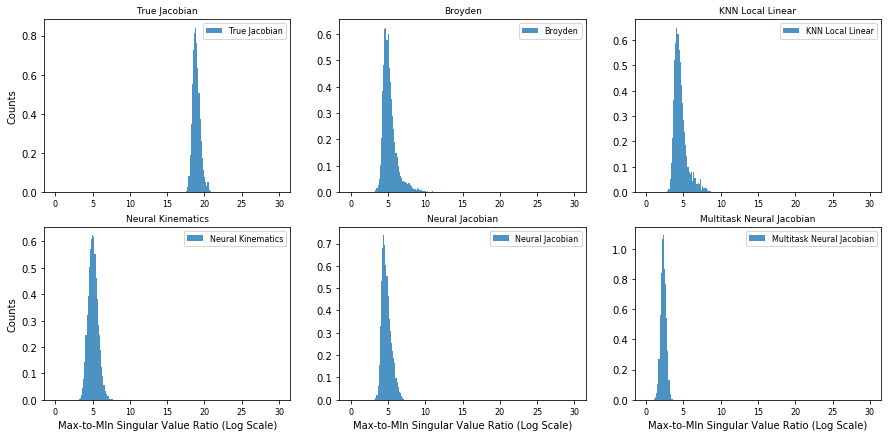

In [29]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# look at the distribution of the singular value ratios for dexterity in workspace
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs = np.ndarray.flatten(axs)
i = 0
for algorithm, result in results.items():
    if "Finite" in algorithm:
        continue
    ax = axs[i]
    i += 1
    singular_val_ratio = singular_values[algorithm]
    singular_val_ratio = np.log(singular_val_ratio.flatten())
    high = max(singular_val_ratio)
    
    ax.hist(singular_val_ratio, bins=200, alpha=0.8, density=True, range=(0, 30), label=algorithm)
    if i == 1 or i == 4:
        ax.set_ylabel('Counts')
    ax.set_title(algorithm)
    ax.legend()
    if i == (len(results) - 1) or i == 4 or i == 6 or i == 5:
        ax.set_xlabel('Max-to-MIn Singular Value Ratio (Log Scale)')

# Check Environment  Conditioning
We just plot the condition numbers of Jacobians in these plots

In [30]:
def check_jacobian_condition(result):
    conditioning_over_time = []
    true_solution_over_time = []
    for k, value in result.items():
        eps_conditioning = []
        true_conditioning = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            #this was backwards.....
            J_hat = v[-2] 
            J = v[-1]
            
            #print("condition numbers:")
            #print("J hat", np.linalg.cond(J_hat), "J", np.linalg.cond(J), "JiJ", np.linalg.cond(JiJ))
            hat_cond = np.linalg.cond(J_hat)
            true_cond = np.linalg.cond(J)
            
            #iJ_hat = np.linalg.pinv(J_hat)
            #JiJ = np.matmul(J, iJ_hat)
            
            #JiJ_cond = np.linalg.cond(JiJ)
            eps_conditioning.append(hat_cond)
            true_conditioning.append(true_cond)
            
        conditioning_over_time.append(eps_conditioning)    
        true_solution_over_time.append(true_conditioning)
    return np.array(conditioning_over_time).T, np.array(true_solution_over_time).T

In [33]:
jac_conds = {}
for i, k_v in enumerate(results.items()):
    algorithm, result = k_v[0], k_v[1]

    cond_hat, cond_true = check_jacobian_condition(result)
    jac_conds[algorithm] = cond_hat

In [34]:
# Checking conditioning of Matrix over episodes & comparing to true jacobian at those points

cond_stats = {}
for i, k_v in enumerate(results.items()):
    algorithm, result = k_v[0], k_v[1]
    #cond_hat, cond_true = check_jacobian_condition(result)
    jac_err = jac_conds[algorithm]
    jac_err = jac_err.flatten()
    print(jac_err.mean(), jac_err.std() )
    cond_stats[algorithm] = {'mean': jac_err.mean(), "standard deviation": jac_err.std()}

    #ax.hist(jac_err, bins=200, alpha=0.8, density=True,
    #        label= algorithm)
    #ax.legend()
    #ax.set_title(algorithm)
    #if i == 1 or i == 4:
    #ax.set_ylabel('Normalized Counts')
    #if i == 6:
    #    ax.set_xlabel("Jacobian Condition Number")
cond_table = pd.DataFrame.from_dict(cond_stats).round(3).transpose()
cond_table

187742580.0 127861420.0
607093118170504.4 5305740209404014.0
3.785612614023027e+16 16.0
184.62178348102313 384.44413480423106
200.78767 174.30818
152.07884 131.37596
10.851724 3.9870353


,mean,standard deviation
Broyden,6.070931e+14,5.305740e+15
Finite Difference,3.785613e+16,1.600000e+01
KNN Local Linear,1.846220e+02,3.844440e+02
Multitask Neural Jacobian,1.085200e+01,3.987000e+00
Neural Jacobian,1.520790e+02,1.313760e+02
Neural Kinematics,2.007880e+02,1.743080e+02
True Jacobian,1.877426e+08,1.278614e+08
